<a href="https://colab.research.google.com/github/katelyn-hucker/xai_hw4/blob/main/ExplainableTechniquesII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Techniques II

## Katie Hucker kh509

This assignment explores the dataset Steam Dataset 2025 (https://www.kaggle.com/datasets/srgiomanhes/steam-games-dataset-2025). After some EDA, I create a RandomForestRegressor trying to predict video game price. I explore ACE, PDP,  and ICE plots.

In [86]:
#install packages if needed
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [40]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

# Models
import xgboost
from sklearn.model_selection import train_test_split

# XAI
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [41]:


# Download latest version
path = kagglehub.dataset_download("srgiomanhes/steam-games-dataset-2025")

print("Path to dataset files:", path)

#this code was taken from the kaggle.com download (https://www.kaggle.com/datasets/srgiomanhes/steam-games-dataset-2025)

Path to dataset files: /root/.cache/kagglehub/datasets/srgiomanhes/steam-games-dataset-2025/versions/3


## Exploratory Data Analysis

In [42]:
file_path = f"{path}/steam_games.csv"
df=pd.read_csv(file_path)
df.head(5)

,steam_appid,name,developers,publishers,categories,genres,required_age,n_achievements,platforms,is_released,...,additional_content,total_reviews,total_positive,total_negative,review_score,review_score_desc,positive_percentual,metacritic,is_free,price_initial (USD)
0,2719580,勇者の伝説の勇者,['ぽけそう'],['ぽけそう'],"['Single-player', 'Family Sharing']","['Casual', 'Indie']",0,0,['windows'],True,...,[],0,0,0,0.0,No user reviews,0.0,0,False,0.99
1,2719590,Light No Fire,['Hello Games'],['Hello Games'],"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Adventure']",0,0,['windows'],False,...,[],0,0,0,0.0,No user reviews,0.0,0,False,0.00
2,2719600,Lorhaven: Cursed War,['GoldenGod Games'],['GoldenGod Games'],"['Single-player', 'Multi-player', 'PvP', 'Shar...","['RPG', 'Strategy']",0,32,"['windows', 'mac']",True,...,[],9,8,1,0.0,9 user reviews,88.9,0,False,9.99
3,2719610,PUIQ: Demons,['Giammnn'],['Giammnn'],"['Single-player', 'Steam Achievements', 'Famil...","['Action', 'Casual', 'Indie', 'RPG']",0,28,['windows'],True,...,[],0,0,0,0.0,No user reviews,0.0,0,False,2.99
4,2719650,Project XSTING,['Saucy Melon'],['Saucy Melon'],"['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Casual', 'Indie', 'Early Access']",0,42,['windows'],True,...,[],9,9,0,0.0,9 user reviews,100.0,0,False,7.99


In [43]:
#Filter for only english titled games
df = df[df['name'].apply(lambda x: x.isascii() if isinstance(x, str) else False)]
#this above line was generated by ChatGPT on 2/5/2024 at 7:20pm

In [44]:
df.columns

Index(['steam_appid', 'name', 'developers', 'publishers', 'categories',
       'genres', 'required_age', 'n_achievements', 'platforms', 'is_released',
       'release_date', 'additional_content', 'total_reviews', 'total_positive',
       'total_negative', 'review_score', 'review_score_desc',
       'positive_percentual', 'metacritic', 'is_free', 'price_initial (USD)'],
      dtype='object')

In [45]:
df = df.drop(columns = ['platforms', 'steam_appid', 'name', 'review_score_desc', 'release_date' ,'additional_content'])

In [46]:
df.dtypes

,0
developers,object
publishers,object
categories,object
genres,object
required_age,int64
n_achievements,int64
is_released,bool
total_reviews,int64
total_positive,int64
total_negative,int64


In [47]:
df.head(5)

,developers,publishers,categories,genres,required_age,n_achievements,is_released,total_reviews,total_positive,total_negative,review_score,positive_percentual,metacritic,is_free,price_initial (USD)
1,['Hello Games'],['Hello Games'],"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Adventure']",0,0,False,0,0,0,0.0,0.0,0,False,0.00
2,['GoldenGod Games'],['GoldenGod Games'],"['Single-player', 'Multi-player', 'PvP', 'Shar...","['RPG', 'Strategy']",0,32,True,9,8,1,0.0,88.9,0,False,9.99
3,['Giammnn'],['Giammnn'],"['Single-player', 'Steam Achievements', 'Famil...","['Action', 'Casual', 'Indie', 'RPG']",0,28,True,0,0,0,0.0,0.0,0,False,2.99
4,['Saucy Melon'],['Saucy Melon'],"['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Casual', 'Indie', 'Early Access']",0,42,True,9,9,0,0.0,100.0,0,False,7.99
5,['Theseus Games'],['Theseus Games'],['Single-player'],['Adventure'],0,0,False,0,0,0,0.0,0.0,0,False,0.00


In [48]:
df.describe()

,required_age,n_achievements,total_reviews,total_positive,total_negative,review_score,positive_percentual,metacritic,price_initial (USD)
count,67582.000000,67582.000000,6.758200e+04,6.758200e+04,67582.000000,67582.000000,67582.000000,67582.000000,67582.000000
mean,2.557811,16.370794,3.822146e+02,3.384945e+02,43.720059,2.226806,46.743908,2.557811,6.476817
std,13.526073,141.715955,7.930950e+03,7.083741e+03,1018.903883,3.187143,41.867235,13.526073,13.117960
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,3.000000e+00,2.000000e+00,0.000000,0.000000,53.800000,0.000000,2.990000
75%,0.000000,16.000000,2.000000e+01,1.500000e+01,4.000000,5.000000,88.400000,0.000000,9.990000
max,97.000000,9821.000000,1.279700e+06,1.107275e+06,172425.000000,9.000000,100.000000,97.000000,999.980000


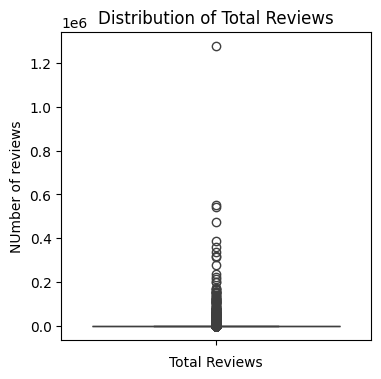

In [49]:
#What does total reviews look like?
plt.figure(figsize=(4, 4))
sns.boxplot(df['total_reviews'])
plt.title("Distribution of Total Reviews")
plt.xlabel("Total Reviews")
plt.ylabel("NUmber of reviews")
plt.show()

In [50]:
#let's only see meaningful games
popular_games = df[
    (df['total_reviews'] > 100)]

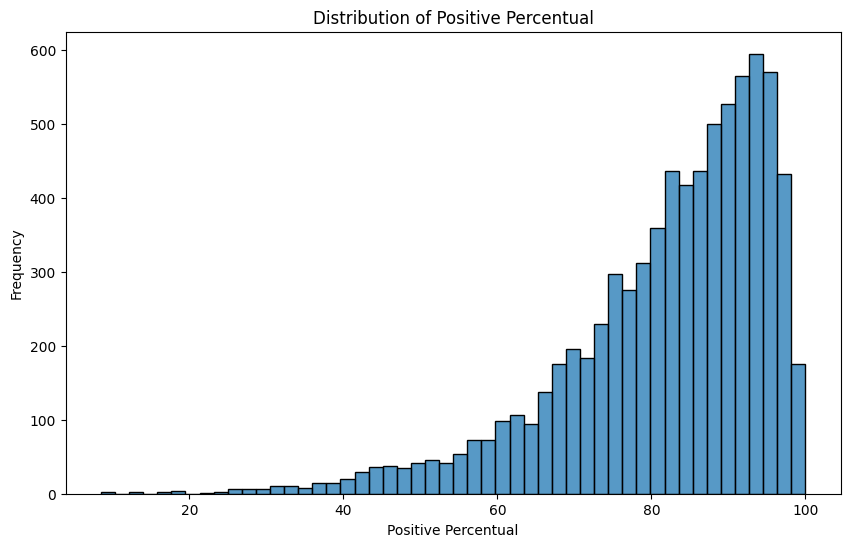

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(popular_games['positive_percentual'], bins=50)
plt.title("Distribution of Positive Percentual")
plt.xlabel("Positive Percentual")
plt.ylabel("Frequency")
plt.show()

In [52]:
popular_games['genres'] = popular_games['genres'].apply(eval)
#This was generated from ChatGPT on 2/5/2025 at 10:34pm

<ipython-input-52-04bb977274d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_games['genres'] = popular_games['genres'].apply(eval)


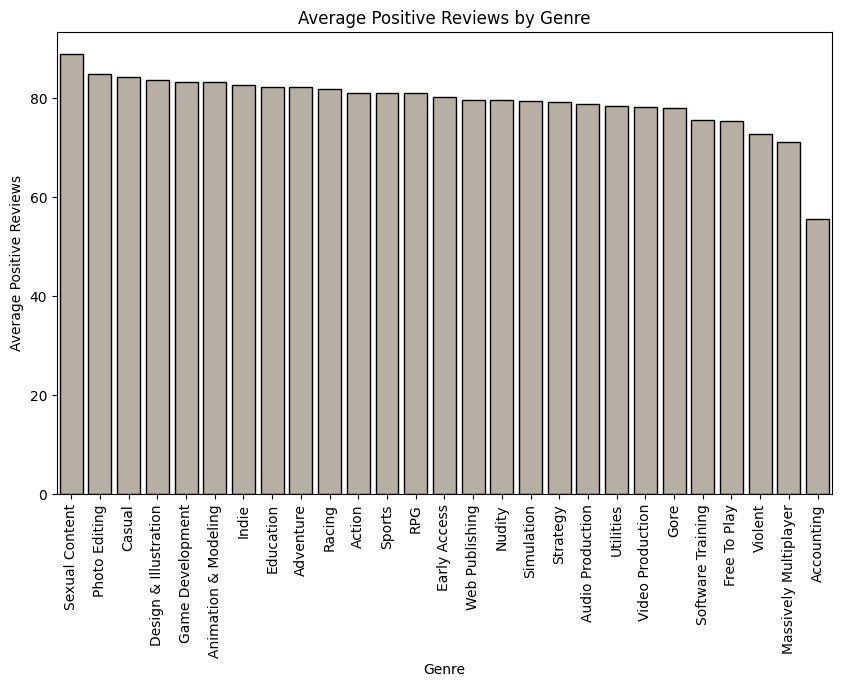

In [53]:
genre_reviews = popular_games.explode('genres').groupby('genres')['positive_percentual'].mean().sort_values(ascending=False)
#The above line of code was generated from ChatGPT at 2/5/2024 at 10:36pm
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_reviews.index, y=genre_reviews.values, color="#baaea1", edgecolor="black")
plt.xticks(rotation=90)
plt.title('Average Positive Reviews by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Positive Reviews')
plt.show()

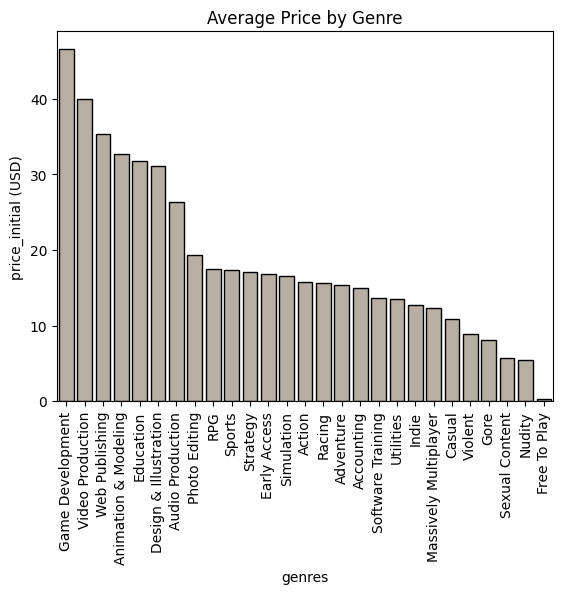

In [54]:
genre_price = popular_games.explode('genres').groupby('genres')['price_initial (USD)'].mean().sort_values(ascending=False)
sns.barplot(x=genre_price.index, y=genre_price, color="#baaea1", edgecolor="black")
plt.xticks(rotation=90)
plt.title('Average Price by Genre')
plt.show()

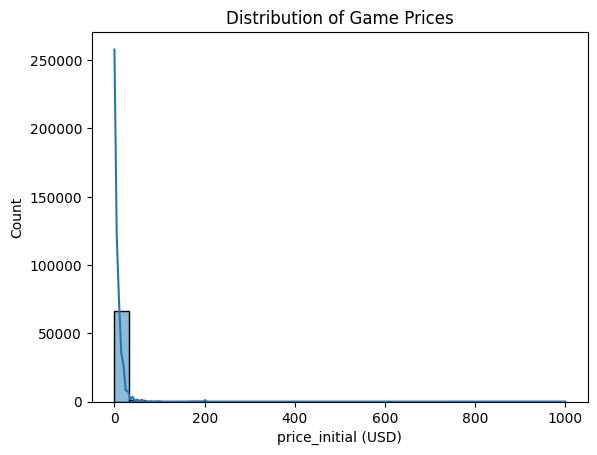

In [55]:
sns.histplot(df['price_initial (USD)'], bins=30, kde=True)
plt.title('Distribution of Game Prices')
plt.show()

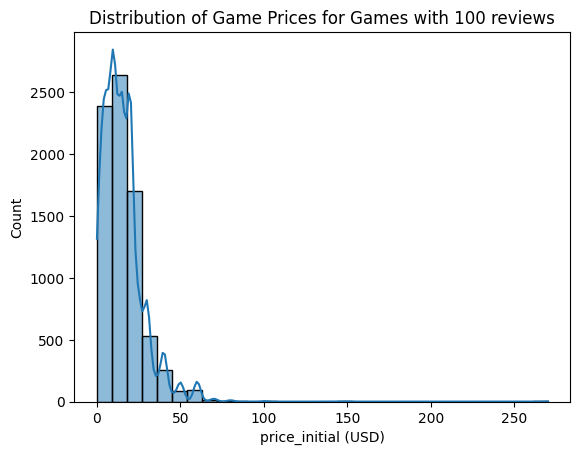

In [56]:
sns.histplot(popular_games['price_initial (USD)'], bins=30, kde=True)
plt.title('Distribution of Game Prices for Games with 100 reviews')
plt.show()

In [58]:
df.rename(columns={'price_initial (USD)': 'price'}, inplace=True)

In [59]:
df = df[df['total_reviews'] > 100]

#### EDA Discussion

I first applied a filter to only English titled games. I then analyzed the following variables looking for trends or things to model:
- number of total reviews
- average positive reviews for each genre (when games have >100 reviews)
- average price for each genre (when games have >100 reviews)
- the distribution of the positive percentual
- price distribution for games both with at least 100 reviews and all games

Trends were more easily found for games with at least 100 reviews. Therefore I will filter the data to only include with games with at least 100 reviews, as this is more realistic to professionally developed games.

Average positive reviews does not seem to differentiate much between genre, however, average price does show some variation between genre. Furthermore, some genres may be on average higher priced to users than others. The distrution of price seems to be minimal unless we filter out some of the games with at least 100 reviews.

Positive percentual shows a left skewed distribution with most of the the scores being a higher positive ratio of user support for games. Total reviews boxplot shows there are a lot of games with little to no reviews.


## Modeling

I will use a RandomForestRegressor model to identify important features for pricing.

#### Set-up for modeling

In [61]:
target_column=df['price']

In [62]:
df["developers"] = df["developers"].apply(lambda x: eval(x)[0] if isinstance(eval(x), list) and len(eval(x)) > 0 else "Unknown")
#the above line of code was generated with ChatGPT at 2/5/2025 11:58pm
df["publishers"] = df["publishers"].apply(lambda x: eval(x)[0] if isinstance(eval(x), list) and len(eval(x)) > 0 else "Unknown")

label_cols = ['developers', 'publishers']

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
#the above for loop using label encoder was generated with ChatGPT at 2/6/2025 1:26 am

In [63]:
df["genres"] = df["genres"].apply(lambda x: eval(x) if isinstance(x, str) else x)

exploded_df = df.explode("genres")
all_genres = exploded_df["genres"].unique()

for genre in all_genres:
    df[genre] = df["genres"].apply(lambda x: genre in x)
#the above for loop was generated with ChatGPT on 2/5/2025 at 11:01pm
df.head()

,developers,publishers,categories,genres,required_age,n_achievements,is_released,total_reviews,total_positive,total_negative,...,Gore,Photo Editing,Education,Software Training,Audio Production,Game Development,Violent,NaN,Sexual Content,Accounting
33,4676,3505,"['Single-player', 'Family Sharing']","[Adventure, Indie]",0,61,True,176,157,19,...,False,False,False,False,False,False,False,False,False,False
78,1482,3533,"['Single-player', 'Steam Achievements', 'Full ...","[Action, Adventure, Early Access]",0,49,True,567,490,77,...,False,False,False,False,False,False,False,False,False,False
84,3380,3764,"['Single-player', 'Steam Cloud', 'Remote Play ...","[Casual, Indie, Strategy]",0,0,True,522,510,12,...,False,False,False,False,False,False,False,False,False,False
93,1352,990,"['Single-player', 'Steam Achievements', 'Parti...","[Adventure, Indie, Simulation]",0,6,True,157,129,28,...,False,False,False,False,False,False,False,False,False,False
133,2039,1516,"['Single-player', 'Steam Achievements', 'Steam...","[Adventure, Casual, Indie, RPG, Simulation]",0,81,True,130,119,11,...,False,False,False,False,False,False,False,False,False,False


In [64]:
df["categories"] = df["categories"].apply(lambda x: eval(x) if isinstance(x, str) else x)

exploded_df = df.explode("categories")
all_genres = exploded_df["categories"].unique()

for genre in all_genres:
    df[genre] = df["categories"].apply(lambda x: genre in x)
#the above for loop was generated with ChatGPT on 2/5/2025 at 11:01pm
df.head()

,developers,publishers,categories,genres,required_age,n_achievements,is_released,total_reviews,total_positive,total_negative,...,Remote Play on TV,Remote Play on Phone,Remote Play on Tablet,Commentary available,VR Support,Steam Turn Notifications,SteamVR Collectibles,Includes Source SDK,Valve Anti-Cheat enabled,Steam Timeline
33,4676,3505,"[Single-player, Family Sharing]","[Adventure, Indie]",0,61,True,176,157,19,...,False,False,False,False,False,False,False,False,False,False
78,1482,3533,"[Single-player, Steam Achievements, Full contr...","[Action, Adventure, Early Access]",0,49,True,567,490,77,...,False,False,False,False,False,False,False,False,False,False
84,3380,3764,"[Single-player, Steam Cloud, Remote Play Toget...","[Casual, Indie, Strategy]",0,0,True,522,510,12,...,False,False,False,False,False,False,False,False,False,False
93,1352,990,"[Single-player, Steam Achievements, Partial Co...","[Adventure, Indie, Simulation]",0,6,True,157,129,28,...,False,False,False,False,False,False,False,False,False,False
133,2039,1516,"[Single-player, Steam Achievements, Steam Trad...","[Adventure, Casual, Indie, RPG, Simulation]",0,81,True,130,119,11,...,False,False,False,False,False,False,False,False,False,False


In [65]:
df.drop(columns=["genres", "categories", "is_released", "is_free"], inplace=True)

#### Model train and test

In [66]:
y = df['price']
X = df.drop(columns=['price'])
X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

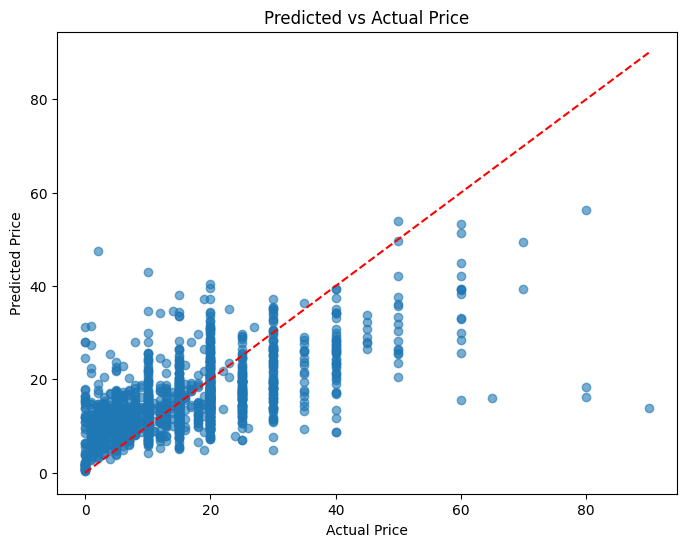

In [67]:
pred_vals = model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_vals, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
#The above line of code was taken from ChatGPT on 2/6/2025 at 1:32am
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

In [68]:
mae = mean_absolute_error(y_test, pred_vals)
rmse = np.sqrt(mean_squared_error(y_test,pred_vals))
r2 = r2_score(y_test, pred_vals)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Absolute Error: 6.63
Root Mean Squared Error: 9.21
R-squared: 0.41


## Explainable Techniques II Plots and Analysis

### PDP

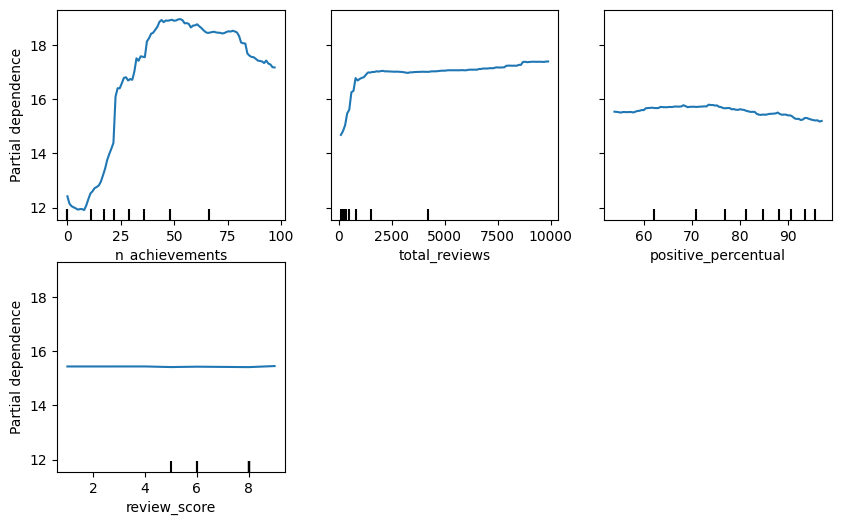

In [75]:
features = ["n_achievements", "total_reviews", "positive_percentual", "review_score"]

fig, ax = plt.subplots(figsize=(10, 6))

PartialDependenceDisplay.from_estimator(model, X_test, features=features, kind='average', ax=ax)
#this code was taken from Dr.Bent's global explanations notebook

plt.show()

#### PDP Discussion

Below is my analysis of the Partial Dependenve Plots for the RandomForestRegressor.

- The feature *n achievements* is non-linear. As the number of achievements increases the prediction price increases. However, it does level out around 30 achievements for the most part. Most video games have achievevments, however, video games with more production typically have more achievements and in-turn are more expensive.

- The feature *total reviews* is non-linear. As the total number of reviews  increases the prediction price increases **until about 2500 reviews.** There is minimal increase to predicted price after that point. Number of reviews typically means the game is larger or widely played. After there is some threshold it seems reviews have no impact on the predicted price.

- The feature *positive percentual* is non-linear. However, is mostly 'level' in nature. Positive percentual shows no impact on the predicted price. This is interesting because it shows that people leave positive ratings no matter the price of the game.

- The feature *review score* is linear with 0 slope. Positive percentual shows no impact on the predicted price. This is interesting because it shows that people leave positive ratings no matter the price of the game.


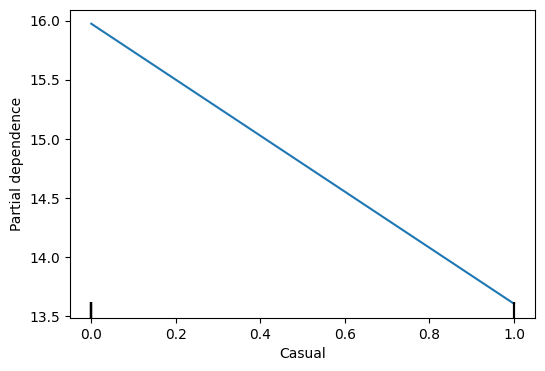

In [82]:
features_bool = ['Casual']
feature_indices = [X_test.columns.get_loc(f) for f in features]
#The above line of code was generated from ChatGPT 2/6/2025 9:18am

fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(model, X_test, features=features_bool, kind='average', ax=ax, categorical_features=feature_indices)
plt.show()

#### Continued analysis for a categorical feature

- The feature boolean genre, *Casual* is linear. However, since it is a categorical feature we only care about the 0 and 1 value on the x-axis.  When a game is not casual it has a higher average predicted price. The opposite occurs for when the game is casual. Casual games are typically smaller in size so it would make sense if the game is cheaper.

### ALE


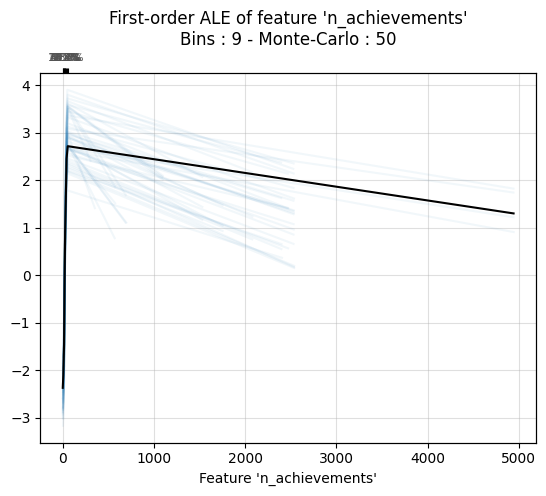

<Axes: title={'center': "First-order ALE of feature 'n_achievements'\nBins : 9 - Monte-Carlo : 50"}, xlabel="Feature 'n_achievements'">

In [70]:
ale_plot(model, X_train, 'n_achievements', monte_carlo=True)
#The above line of code was referenced from global_explanations.ipynb by Dr.Bent

#### ALE Plot interpretation

- The number of achievements shows moderate impact on predicted price. It is downward curve which means number of achievements decreases predictions. Number of achievements provides information to the model with a moderate impact.

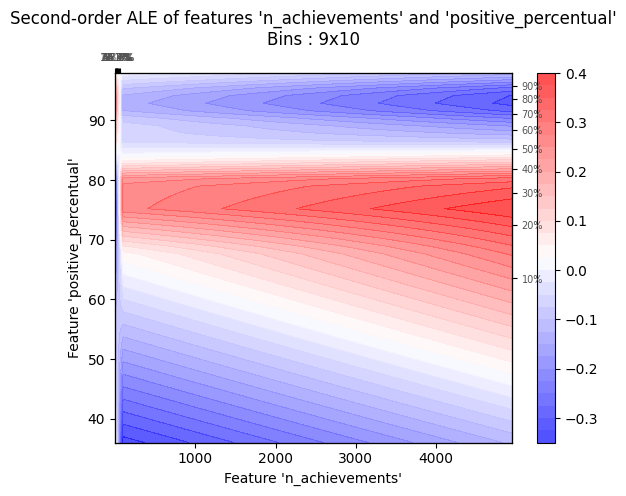

<Axes: title={'center': "Second-order ALE of features 'n_achievements' and 'positive_percentual'\nBins : 9x10"}, xlabel="Feature 'n_achievements'", ylabel="Feature 'positive_percentual'">

In [85]:
temp_cols = ['n_achievements', 'positive_percentual']
ale_plot(model, X_train, temp_cols, bins=10)
#The above line of code was referenced from global_explanations.ipynb by Dr.Bent

#### ALE 2nd Order Plot Discussion:

As positive percentuals within value of 60-80 the number of achievements interaction causes a positive effect. The more achievements seems to give a positive effect at wider ranges of positive percentual.

The upper region  is predominantly blue, indicating that increasing the number of achievements in this range tends to decrease predictions. This is the same for the upper region.

The slope variations show a non-linear relationship between these features and the model’s predictions.


### ICE

In [73]:
features

['n_achievements', 'total_reviews', 'positive_percentual', 'review_score']

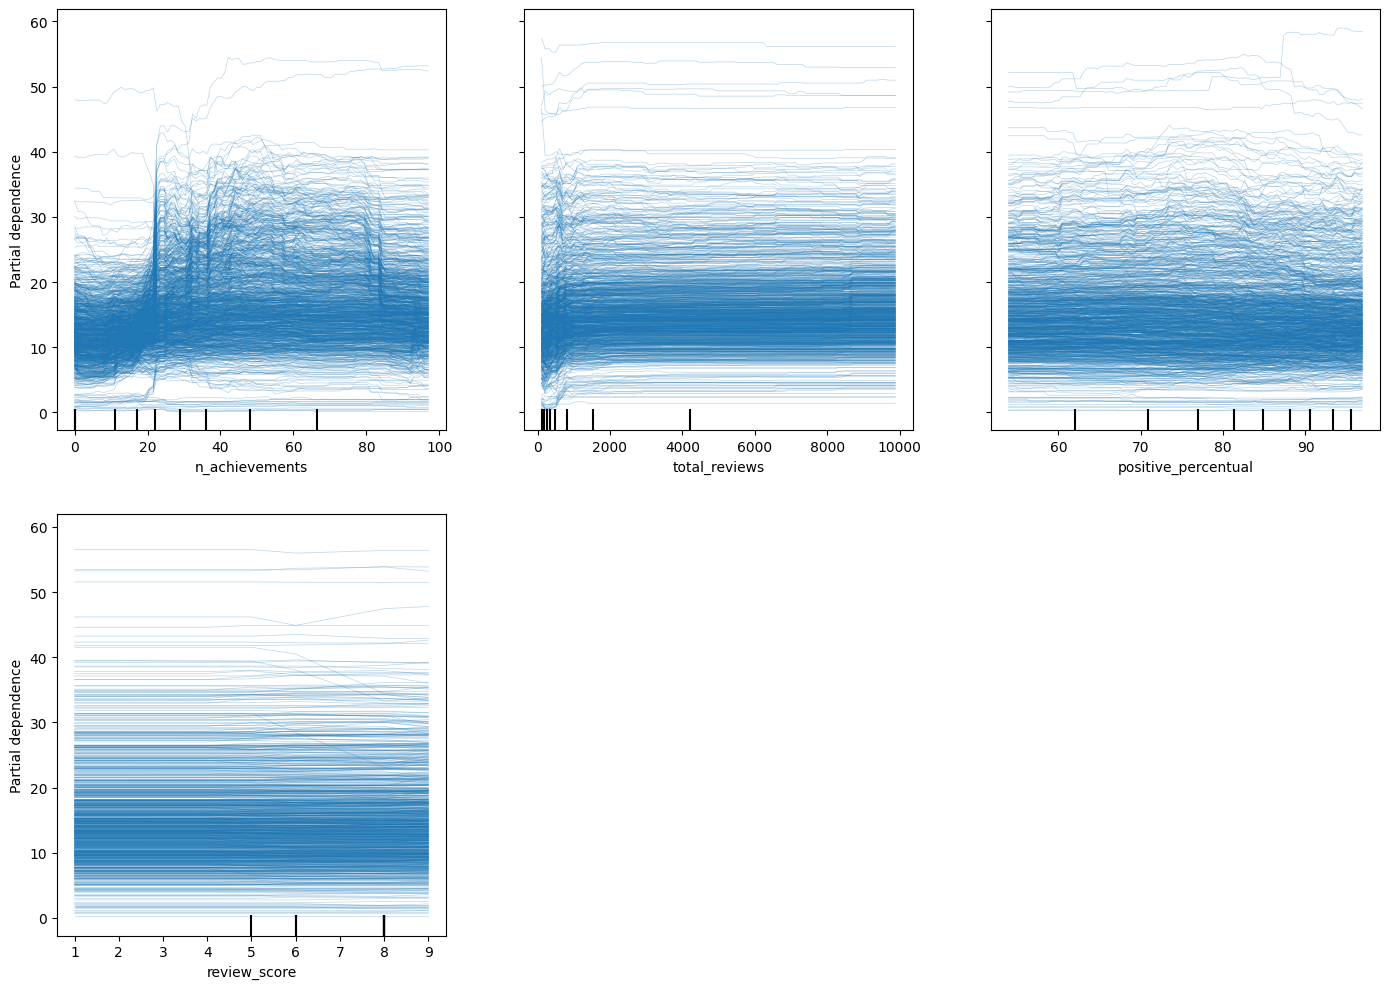

In [74]:
fig, ax = plt.subplots(figsize=(14, 10))
display = PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual', ax=ax)
#The above line of code was referenced from local_explanations.ipynb by Dr.Bent
plt.tight_layout()
plt.show()

#### ICE Plots interpretations


- The feature *n achievements* shows a spike around 20 achievements, across all instances. This shows that a moderate amount of achievements will increase your game price.

- The feature *total reviews* shows minimal effect on price. We could probably remove this from our random forest model.

- The feature *positive percentual* shows variation across all instances. There is one line which as a big jump in price at about 80% positive percentual.There are others which show 'jumpiness,' with a over-time decreasing trend. This shows that positive ratings does not necessarily mean a more expensive game.

- The feature *review score* instances mostly all show 0 slope. There is no effect on price with the different review scores.